In [1]:
# From Python
# It requires OpenCV installed for Python
import sys
import cv2
import os
from sys import platform
import argparse
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import Openpose (Windows/Ubuntu/OSX)
dir_path = os.path.dirname(os.path.realpath('__file__'))
try:
    # Change these variables to point to the correct folder (Release/x64 etc.)
    sys.path.append(dir_path + '/../bin/python/openpose/Release');
    os.environ['PATH']  = os.environ['PATH'] + ';' + dir_path + '/../x64/Release;' +  dir_path + '/../bin;'
    import pyopenpose as op
except ImportError as e:
    print('Error: OpenPose library could not be found. Did you enable `BUILD_PYTHON` in CMake and have this Python script in the right folder?')
    raise e

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument("--image_path", default="../examples/media/COCO_val2014_000000000241.jpg", help="Process an image. Read all standard formats (jpg, png, bmp, etc.).")
args = parser.parse_known_args()

# Custom Params (refer to include/openpose/flags.hpp for more parameters)
params = dict()
params["model_folder"] = "../models/"
params["hand"] = True
params["hand_detector"] = 2
params["body"] = 0

# Add others in path?
for i in range(0, len(args[1])):
    curr_item = args[1][i]
    if i != len(args[1])-1: next_item = args[1][i+1]
    else: next_item = "1"
    if "--" in curr_item and "--" in next_item:
        key = curr_item.replace('-','')
        if key not in params:  params[key] = "1"
    elif "--" in curr_item and "--" not in next_item:
        key = curr_item.replace('-','')
        if key not in params: params[key] = next_item

# Starting OpenPose
opWrapper = op.WrapperPython()
opWrapper.configure(params)
opWrapper.start()

# Read image and face rectangle locations
image_path = "../examples/media/COCO_val2014_000000000241.jpg"
imageToProcess = cv2.imread(image_path)

In [28]:
# Import Openpose (Windows/Ubuntu/OSX)
dir_path = os.path.dirname(os.path.realpath('__file__'))
try:
    # Change these variables to point to the correct folder (Release/x64 etc.)
    sys.path.append(dir_path + '/../bin/python/openpose/Release');
    os.environ['PATH']  = os.environ['PATH'] + ';' + dir_path + '/../x64/Release;' +  dir_path + '/../bin;'
    import pyopenpose as op
except ImportError as e:
    print('Error: OpenPose library could not be found. Did you enable `BUILD_PYTHON` in CMake and have this Python script in the right folder?')
    raise e
    
def extend_hand_box(box, image_height, image_width, extend):
    xmin, ymin, xmax, ymax = box 
    for i in range(extend):
        if xmin == 0 and xmax < image_width: 
            xmax += 1
            extend += 1
        elif xmin > 0 and xmax == image_width: 
            xmin -= 1
            extend += 1
        elif xmin <= 0 and xmax >= image_width:
            pass
        else: 
            xmin, xmax = xmin - 1, xmax + 1

        if ymin == 0 and ymax < image_height: 
            ymax += 1
            extend += 1
        elif ymin > 0 and ymax == image_height:
            ymin -= 1
            extend += 1
        elif ymin <= 0 and ymax >= image_height:
            pass
        else: 
            ymin, ymax = ymin - 1, ymax + 1
    
    xmin = 0 if xmin<0 else xmin
    ymin = 0 if ymin<0 else ymin
    xmax = image_width if xmax > image_width else xmax
    ymax = image_height if ymax > image_height else ymax
    
    return xmin, ymin, xmax, ymax

def find_bounded_sqaure(box):
    xmin, ymin, xmax, ymax = box 
    x = (xmax-xmin)/2 + xmin
    y = (ymax-ymin)/2 + ymin
    extend = max(xmax-xmin, ymax-ymin)/2 
    new_xmin, new_ymin = x-extend, y-extend
    new_xmax, new_ymax = x+extend, y+extend
    return new_xmin, new_ymin, new_xmax, new_ymax

def convert_to_op_rectangle(box, image_height, image_width, extend=50):
    bounded_sqaure = find_bounded_sqaure(box)
    xmin, ymin, xmax, ymax = extend_hand_box(bounded_sqaure, image_height, image_width, extend)
    width = abs(xmax - xmin)
    height = abs(ymax - ymin)
    length = max(width, height)
    hand_rectangle = op.Rectangle(xmin, ymin, length, length)
    return hand_rectangle

In [29]:
# From body pose 
hand_boxes = [[243.48513793945312, 347.7793884277344, 287.4617004394531, 401.5953674316406],
             [125.08369445800781, 303.3705139160156, 161.65296936035156, 348.0794372558594],
             [99.85457611083984, 432.2530822753906, 128.92103576660156, 463.9233093261719],
             [75.73243713378906, 435.4949035644531, 108.15406799316406, 469.2543029785156],
             [337.4364318847656, 403.0123291015625, 365.2542419433594, 423.7030029296875]]

height, width = imageToProcess.shape[:2]
handRectangles = [[convert_to_op_rectangle(box, height, width, 30), op.Rectangle(0., 0., 0., 0.)] for box in hand_boxes]

# Provided by openpose
# handRectangles = [
#         # Left/Right hands person 1
#         [
#         op.Rectangle(185.692673, 303.112244, 157.587555, 157.587555),
#         op.Rectangle(88.984360, 268.866547, 117.818230, 117.818230)
#         ],
#         # Left/Right hands person 2
#         [
#         op.Rectangle(80.155792, 407.673492, 80.812706, 80.812706),
#         op.Rectangle(46.449715, 404.559753, 98.898178, 98.898178)
#         ],
#         # Left/Right hands person 3
#         [
#         op.Rectangle(0., 0., 0., 0.),
#          op.Rectangle(320.035889, 377.675049, 69.300949, 69.300949)
#         ]
#     ]

# Create new datum
datum = op.Datum()
datum.cvInputData = imageToProcess
datum.handRectangles = handRectangles

# Process and display image
opWrapper.emplaceAndPop(op.VectorDatum([datum]))
print("Left hand keypoints: \n" + str(datum.handKeypoints[0]))
print("Right hand keypoints: \n" + str(datum.handKeypoints[1]))

keypoints = datum.handKeypoints

Left hand keypoints: 
[[[2.72586914e+02 3.51181915e+02 6.67974353e-01]
  [2.61762024e+02 3.57676849e+02 7.16474533e-01]
  [2.51864990e+02 3.70357422e+02 8.46697152e-01]
  [2.49390732e+02 3.82728729e+02 7.97975957e-01]
  [2.47535034e+02 3.91388641e+02 8.94345939e-01]
  [2.57432068e+02 3.82728729e+02 7.67493010e-01]
  [2.53720688e+02 3.95718597e+02 8.76836121e-01]
  [2.53102112e+02 3.91079346e+02 3.84512454e-01]
  [2.54339249e+02 3.87367950e+02 3.78523797e-01]
  [2.66401276e+02 3.82728729e+02 7.59419680e-01]
  [2.61762024e+02 3.97265015e+02 7.97452748e-01]
  [2.61143463e+02 3.90770081e+02 6.05785370e-01]
  [2.61143463e+02 3.84584412e+02 5.41201293e-01]
  [2.73824036e+02 3.80873016e+02 8.77699375e-01]
  [2.69184814e+02 3.93244324e+02 8.21727693e-01]
  [2.67947693e+02 3.89223663e+02 6.20715380e-01]
  [2.67019836e+02 3.83965851e+02 4.79993492e-01]
  [2.79081848e+02 3.78708038e+02 8.57352734e-01]
  [2.76298309e+02 3.88914368e+02 8.70374739e-01]
  [2.73824036e+02 3.87058685e+02 6.89579904e-01

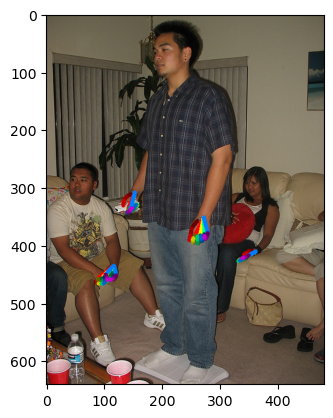

In [30]:
# Extracted from openpose rendering
HAND_PAIRS  =  [0,1,  1,2,  2,3,  3,4,  0,5,  5,6,  6,7,  7,8,  0,9,  9,10,  10,11,  11,12,  0,13,  13,14,  14,15,  15,16,  0,17,  17,18,  18,19,  19,20]
HAND_COLORS =  [
    100,  100,  100, \
    100,    0,    0, \
    150,    0,    0, \
    200,    0,    0, \
    255,    0,    0, \
    100,  100,    0, \
    150,  150,    0, \
    200,  200,    0, \
    255,  255,    0, \
      0,  100,   50, \
      0,  150,   75, \
      0,  200,  100, \
      0,  255,  125, \
      0,   50,  100, \
      0,   75,  150, \
      0,  100,  200, \
      0,  125,  255, \
    100,    0,  100, \
    150,    0,  150, \
    200,    0,  200, \
    255,    0,  255 ]

def draw_hand_keypoints(keypoints, image_np):
    for hand_list in keypoints:
        for hand in hand_list:
            for i in range(0,len(HAND_PAIRS),2):
                i0,i1  = HAND_PAIRS[i], HAND_PAIRS[i+1]
                p0,p1 = tuple(hand[i0,:2].astype(int)), tuple(hand[i1,:2].astype(int))
                color = tuple(HAND_COLORS[int(i/2)*3:(int(i/2)*3) + 3])
                cv2.line(image_np,p0,p1,color,thickness=5,lineType=8)
                
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

draw_hand_keypoints(keypoints, image)

plt.imshow(image)
plt.show()

In [15]:
def get_predicted_keypoints_coordinates(keypoints):
    no = 0
    coordinates = []
    for hand_list in keypoints:
        for hand in hand_list:
            this_hand = []
            no += 1
            print("hand no: " + str(no))
            for i in range(21):
                this_hand.append(list(hand[i,:2]))
                print(list(hand[i,:2]))
            coordinates.append(this_hand)
    return coordinates

coordinates = get_predicted_keypoints_coordinates(keypoints)

hand no: 1
[272.90698, 350.20563]
[261.16977, 358.4217]
[251.78, 368.9852]
[248.65007, 382.28738]
[248.65007, 390.50342]
[258.03986, 382.67862]
[253.34496, 395.1983]
[252.95372, 392.85086]
[254.12744, 389.3297]
[267.0384, 381.50488]
[261.95224, 396.37204]
[261.16977, 391.28592]
[260.3873, 385.80853]
[273.68948, 380.7224]
[270.1683, 393.2421]
[267.82086, 389.72095]
[267.0384, 383.85233]
[279.16684, 379.15744]
[276.42816, 389.3297]
[273.68948, 386.98227]
[273.68948, 383.4611]
hand no: 2
[153.75948, 308.2951]
[147.07945, 312.00623]
[139.65721, 315.34625]
[134.09053, 322.02628]
[132.23497, 330.19073]
[142.25499, 332.0463]
[148.5639, 338.72632]
[154.13058, 334.64407]
[156.72836, 328.7063]
[144.85278, 340.95297]
[147.07945, 342.0663]
[152.27502, 335.75742]
[155.24393, 329.8196]
[142.6261, 339.0974]
[139.2861, 343.92188]
[134.09053, 343.92188]
[128.15273, 343.55078]
[144.11055, 340.95297]
[137.80165, 343.55078]
[133.3483, 343.92188]
[147.82167, 335.0152]
hand no: 3
[183.4597, 510.36005]
[185.